## Contributions

In [87]:
%run setup.ipynb
import json
from scipy.stats import chi2
import sys

In [88]:
cwd = os.getcwd()
base_dir = os.path.abspath(os.path.join(cwd, "../"))  # For interactive mode (Jupyter/IPython)
pythonPath = os.path.join(base_dir, 'python', 'nonstationaryGEV')
sys.path.append(pythonPath)

from imports import make_directoryDict
from plotting import plotTimeDependentReturnValue
from helpers import adjust_w_for_plotting


In [89]:
# set up directories to read from
dirs = make_directoryDict(base_dir)

In [90]:
recordID =57
climateIndex = ['AO','AAO','BEST','DMI','ONI','PDO','PMM','PNA','TNA']

In [91]:
#%%
# Initialize an empty list to store results
results = []
SignifCvte1 = np.zeros(len(climateIndex))
w_nodal = np.zeros(len(climateIndex))
w_cvte1 = np.zeros(len(climateIndex))

for i in np.arange(0, len(climateIndex)):
    #read first value of w from trend_params.json
    nodal_params = 'nodal_params.json'
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / nodal_params
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w_nodal[i] = output['w'][0]

    covariate_params = f'cvte_location_params_{climateIndex[i]}.json'
    
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

    # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w, mio, standard_error,x = (np.array(output[key]) for key in ['w', 'mio', 'standard_error','x'])

    wfull = adjust_w_for_plotting(x,w)

    # prepend standard error with 0 to match the size of w
    standard_error = np.insert(standard_error, 0, 0)
    
    standard_error = adjust_w_for_plotting(x,standard_error)

    # Store the results in a list
    results.append({
        'Climate Index': climateIndex[i],
        'CI param': wfull[10],  
        'Standard Error of CI param': standard_error[10]
    })

    # Compute deviance statistic
    w_cvte1[i] = w[0]
    diffe = w_cvte1[i] - w_nodal[i]
    p = 1
    SignifCvte1[i] = chi2.cdf(2 * diffe, p)

# Convert the results list to a DataFrame
df_cvteLocation = pd.DataFrame(results)

# add Significance to the dataframe
df_cvteLocation['Significance (over Nodal)'] = SignifCvte1

df_cvteLocation


,Climate Index,CI param,Standard Error of CI param,Significance (over Nodal)
0,AO,0.003890,0.004604,0.601860
1,AAO,0.002139,0.004426,0.371100
2,BEST,0.001435,0.003598,0.309628
3,DMI,-0.005603,0.003743,0.864523
4,ONI,-0.001742,0.003467,0.385210
5,PDO,0.018224,0.004182,0.999984
6,PMM,0.021682,0.003617,1.000000
7,PNA,-0.006113,0.004915,0.785167
8,TNA,0.007201,0.004122,0.922325


In [92]:
x

array([1, 1, 0, 1, 1, 0, 1])

Text(0.5, 0, 'Climate Index')

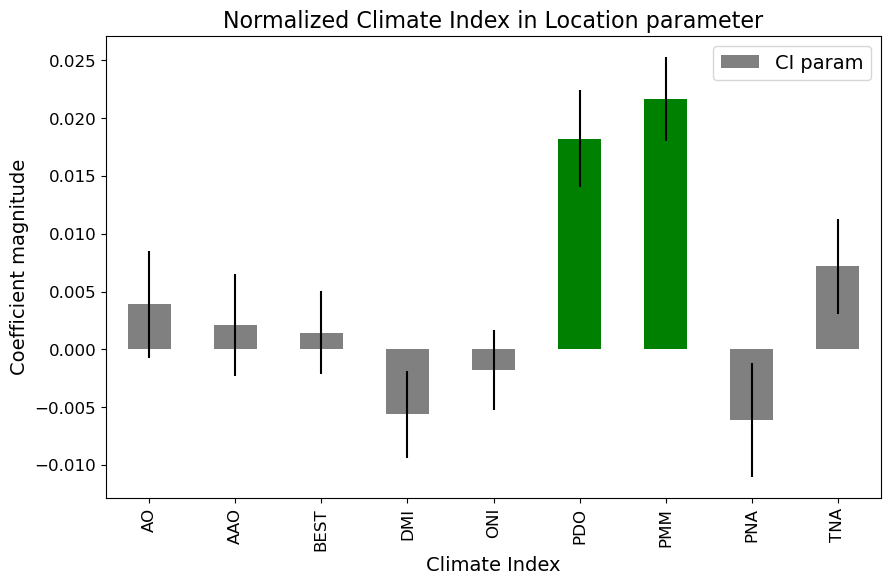

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors based on significance
location_colors = np.where(df_cvteLocation['Significance (over Nodal)']>0.95, 'green', 'gray')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the Location parameter with custom colors for significance
df_cvteLocation.plot(
    x='Climate Index', 
    y='CI param', 
    yerr='Standard Error of CI param', 
    kind='bar',  
    ax=ax,
    color=location_colors
)
ax.set_title('Normalized Climate Index in Location parameter')
ax.set_ylabel('Coefficient magnitude')
ax.set_xlabel('Climate Index')




Text(0.5, 1.0, 'Return Levels: Honolulu, Hawaii')

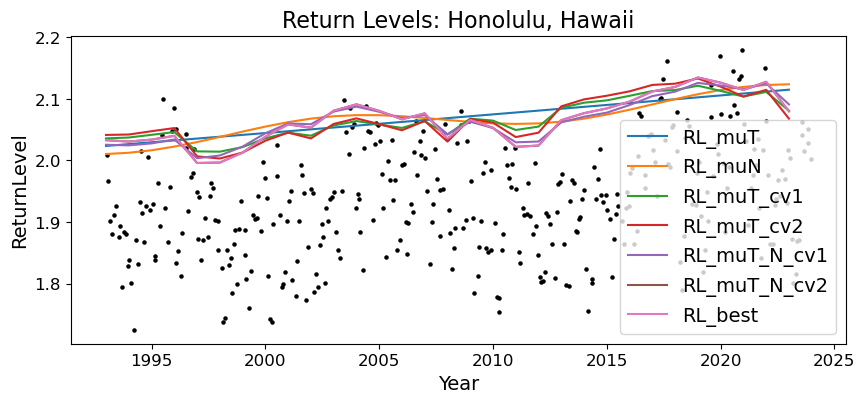

In [94]:
# load in the best model from C:\Users\julia\Documents\GitHub\SL_Hawaii\data\GEV_model_output\57\RL_best.nc
# and plot the return level curve

modelTypes = ['RL_muT', 'RL_muN','RL_muT_cv1','RL_muT_cv2','RL_muT_N_cv1','RL_muT_N_cv2','RL_best']

for modelType in modelTypes:
    modelName = modelType + '.nc'
    modelPath = Path(dirs['model_output_dir'] / str(recordID) / modelName)
    model = xr.open_dataset(modelPath)

    model['ReturnLevel'].sel(ReturnPeriod=2).plot()

plt.legend(modelTypes)

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

time = modelInfo['year0'] + pd.Series(modelInfo['t'])
plt.scatter(time, modelInfo['monthlyMax'], color='k', label='Monthly Maxima', s=5)

plt.title('Return Levels: ' + model.attrs['station_name'])



In [95]:

w = adjust_w_for_plotting(x, params)

def plot_location(w, modelInfo, label, offset=0, component=True):
    # Unpack the w array
    b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
    a0, bLT, bCI, aCI, bN1, bN2 = w[1], w[9], w[10], w[11], w[12], w[13]

    # Check if w[10] (bCI) is zero (i.e., no covariate contribution)
    if bCI == 0:
        ti = np.arange(0, modelInfo['t'][-1], 0.01)
        CI = 0  # Covariate is zero if bCI is zero
    else:
        ti = pd.Series(modelInfo['t']) 
        CI = pd.Series(modelInfo['covariate'])  # Covariate values

        

    # Make sure CI and ti are aligned (if CI is a series)
    if isinstance(CI, pd.Series) and len(CI) != len(ti):
        raise ValueError("Length of covariate CI does not match the length of ti.")

    # Define mut (location(t)) as a function of ti and CI
    mut = (b0 * np.exp(bLT * ti) +
           b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
           b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
           b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
           bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
           (bCI * CI))  

    # Calculate the amplitudes for each harmonic and the covariate
    amp_annual = np.sqrt(b1**2 + b2**2)      # First harmonic (annual cycle)
    amp_semiannual = np.sqrt(b3**2 + b4**2)  # Second harmonic (semiannual cycle)
    amp_third = np.sqrt(b5**2 + b6**2)       # Third harmonic (quarterly or 8π cycle)
    amp_nodal = np.sqrt(bN1**2 + bN2**2)     # Nodal component
    amp_covariate = abs(bCI)                 # Covariate amplitude
    amp_trend = 0.5*(b0 * np.exp(bLT * modelInfo['t'][-1]) - b0*np.exp(bLT * modelInfo['t'][0]))  # Trend amplitude



    amp_seasonal = np.sqrt(amp_annual**2 + amp_semiannual**2 + amp_third**2)
    
    # Calculate the total amplitude
    amp = np.sqrt(amp_seasonal**2 + amp_nodal**2 + amp_covariate**2 + amp_trend**2)
    


    # Subtract the datum offset
    mut = mut - modelInfo['STNDtoMHHW']

    if component:
        mut_demeaned = mut - np.mean(mut)
    else:
        mut_demeaned = mut
    
    # mut_demeaned = mut_demeaned - modelInfo['STNDtoMHHW']
    
    # add zero line for reference in gray
    plt.axhline(y=offset, color='gray', linestyle='-.', alpha=0.5)

    # Plot the result

    plt.plot(ti+modelInfo['year0'], mut_demeaned + offset, label=label + ' ( ' + str(round(2*amp*100, 2)) + ' cm)') 
    return amp



In [96]:
# Make figure
def make_component_figure(w, modelInfo, model, time):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    returnYear = 10

    # Add 50-year return level to the plot
    plt.plot(model['Year']+0.5, 
            model['ReturnLevel'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
            label=f'{returnYear}-year Return Level', color='black', linewidth=2) 

    # add error bars as shaded area from model['RL_low'] to model['RL_high']
    plt.fill_between(model['Year']+0.5, 
                    model['RL_high'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
                    model['RL_low'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'],
                    color='gray', alpha=0.2)

    # Add monthly maxima, centered
    mm = np.array(modelInfo['monthlyMax']) - modelInfo['STNDtoMHHW']
    plt.scatter(time, mm, color='gray', label='Monthly Maxima', s=5)
    amp_full = plot_location(w, modelInfo, label='Full $\mu(t)$', offset=0, component=False)

    # First plot: Covariate contribution
    wnew = np.zeros(len(w))
    wnew[10] = w[10]  # Only use the covariate component
    offset1 = -0.2  # Offset for the plot
    amp_CI = plot_location(wnew, modelInfo, label=modelInfo['covariateName'] , offset=offset1)


    # Second plot: Seasonal components
    wnew = np.zeros(len(w))
    wnew[1:9] = w[1:9]  # Seasonal components
    offset1 -= 0.2  # Increment offset correctly
    amp_S = plot_location(wnew, modelInfo, label='Seasonal', offset=offset1)

    # Third plot: Long-term trend
    wnew = np.zeros(len(w))
    wnew[9] = w[9]  # Long-term trend component
    wnew[0] = w[0]  # Plus base value
    offset1 -= 0.2  # Increment offset correctly
    amp_LT = plot_location(wnew, modelInfo, label='Long-term trend', offset=offset1)


    # Fourth plot: Nodal component
    wnew = np.zeros(len(w))
    wnew[12:14] = w[12:14]  # Nodal components
    offset1 -= 0.2  # Increment offset correctly
    amp_N = plot_location(wnew, modelInfo, label='Nodal', offset=offset1)

    plt.title('Location Parameter Components: ' + model.attrs['station_name'])
    plt.xlim(modelInfo['t'][0] + modelInfo['year0'], modelInfo['t'][-1] + modelInfo['year0'])
    plt.ylabel('Height above MHHW (m)')

    # Add legend to the outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # add a second y-axis on the right side to label components
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0, offset1-0.2, -0.2))
    ax2.set_yticklabels(['Full $\mu(t)$',
                      modelInfo['covariateName'] + ' $\mu_{CI}(t)$' , 
                      'Seasonal $\mu_{S}(t)$', 
                      'Long-term trend $\mu_{LT}(t)$', 
                      'Nodal $\mu_{N}(t)$']); #not sure why there's output here but I've suppressed it
    amps = [amp_full, amp_CI, amp_S, amp_LT, amp_N]
    amp_names = ['Full', 'Covariate', 'Seasonal', 'Long-term trend', 'Nodal']
    amps = dict(zip(amp_names, amps))
    return fig, amps


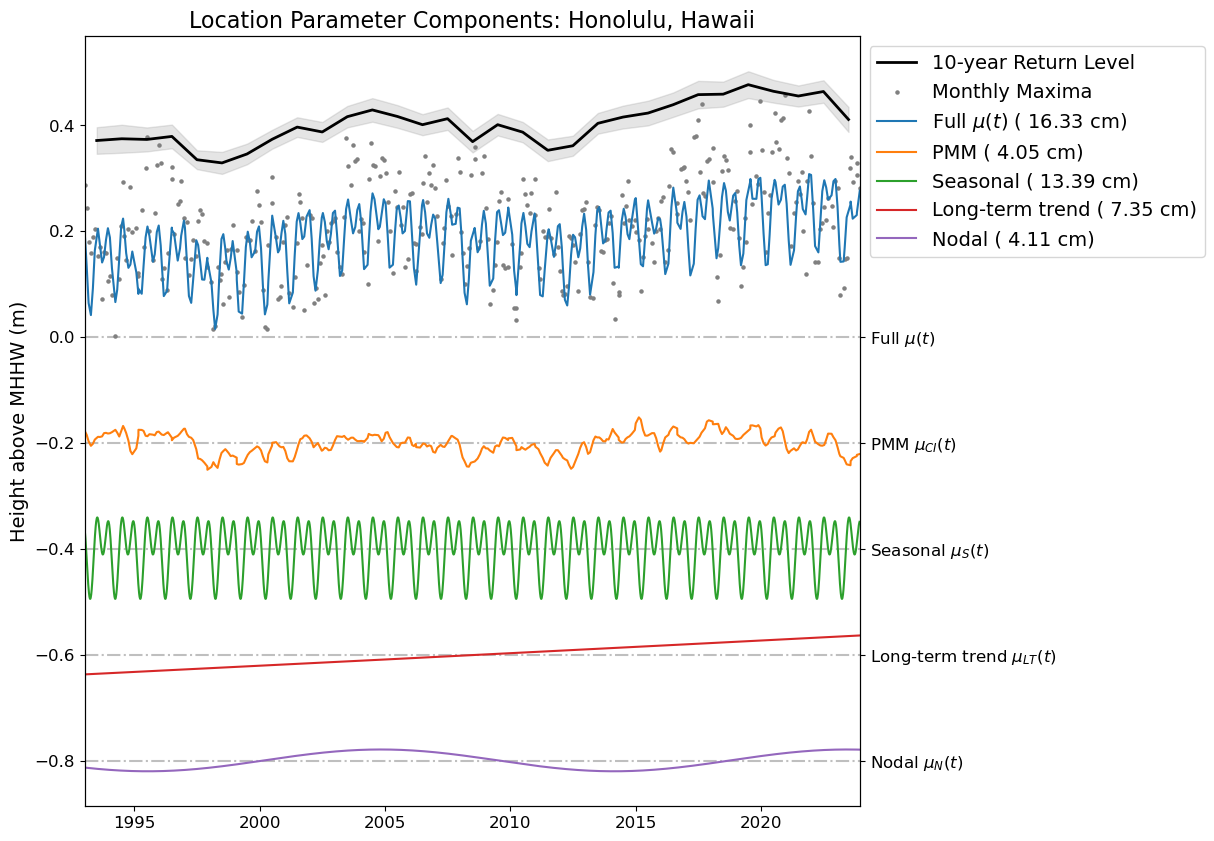

In [97]:
fig, amps = make_component_figure(w, modelInfo, model, time)

In [98]:
# save amps to a json file
amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
with open(amps_json, 'w') as f:
    json.dump(amps, f)

The following code can only be run after all gauges have been modeled!

In [118]:
# get all location_parms_component_amp.json files and combine them into one
amps = {}

# get list of all directories in dirs['model_output_dir']
dirs_list = os.listdir(dirs['model_output_dir'])

for recordID in dirs_list:
    amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
    with open(amps_json, 'r') as f:
        amps[recordID] = json.load(f)


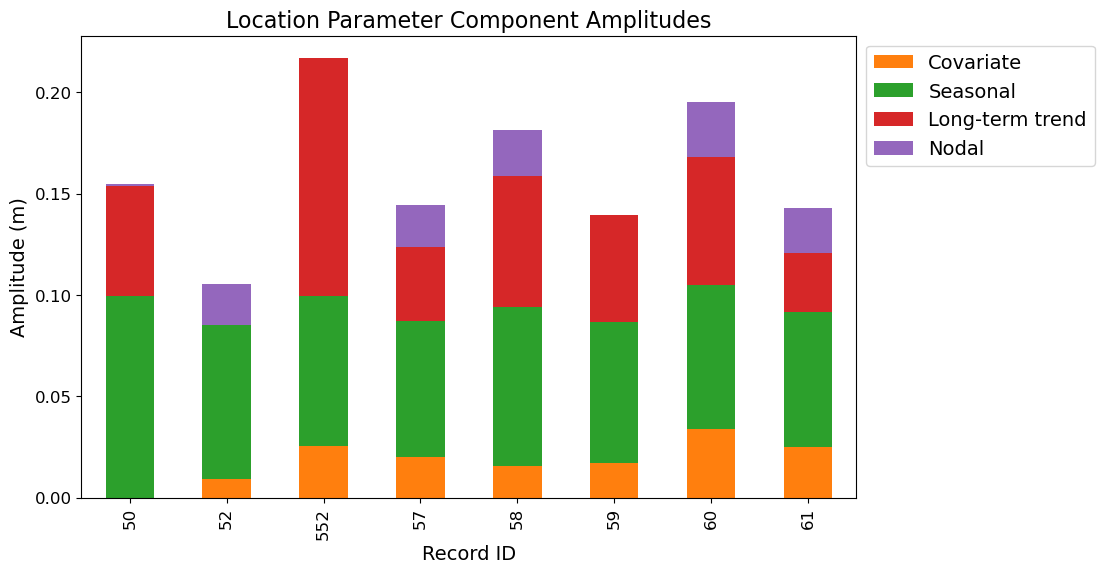

In [119]:
#plot df as stacked bar chart ignoring the full component
#turn amps into a dataframe
df = pd.DataFrame(amps).T
df = df.drop('Full', axis=1)

# reorder columns to match above plot
df = df[['Covariate', 'Seasonal', 'Long-term trend', 'Nodal']]


df.plot(kind='bar', stacked=True, figsize=(10, 6),color=plt.cm.tab10.colors[1:])
plt.title('Location Parameter Component Amplitudes')
plt.ylabel('Amplitude (m)')
plt.xlabel('Record ID')
plt.legend(title='Component')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


# ,Location= 'upper right', bbox_to_anchor=(1, 1))